In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from datasets import load_dataset
data = load_dataset('akariasai/PopQA')['test']
print(data[0].keys())
for i in range(10):
    print(json.dumps(data[i]['possible_answers'], indent=4))

Repo card metadata block was not found. Setting CardData to empty.


dict_keys(['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers'])
"[\"politician\", \"political leader\", \"political figure\", \"polit.\", \"pol\"]"
"[\"journalist\", \"journo\", \"journalists\"]"
"[\"politician\", \"political leader\", \"political figure\", \"polit.\", \"pol\"]"
"[\"politician\", \"political leader\", \"political figure\", \"polit.\", \"pol\"]"
"[\"cartoonist\", \"graphic artist\", \"animator\", \"illustrator\"]"
"[\"mathematician\", \"economist\", \"economists\"]"
"[\"talent manager\", \"artist manager\", \"band manager\", \"music manager\", \"musician manager\", \"manager\", \"pop entrepreneur\"]"
"[\"politician\", \"political leader\", \"political figure\", \"polit.\", \"pol\"]"
"[\"politician\", \"political leader\", \"political figure\", \"polit.\", \"pol\"]"
"[\"actor\", \"actress\", \"actors\", \"actresses\"]"


In [2]:
from datasets import Dataset


def questions_raw(d):
    q = []
    for i in range(len(d)):
        q.append(d[i]['question'])
    return q

def dedup_raw(d):
    q = set()
    o = []
    for i in range(len(d)):
        if d[i]['question'] in q:
            continue
        q.add(d[i]['question'])
        o.append(d[i])
    return Dataset.from_list(o)

# create splits

In [4]:
import math
import os


thresholds = [0, 1000, 10000, 100000, math.inf]
for lo, hi in zip(thresholds[:-1], thresholds[1:]):
    data_lo_hi = data.filter(lambda x: lo <= x['s_pop'] < hi)
    data_lo_hi.to_parquet(f'../data/raw/s_pop_{lo}_to_{hi}.parquet')
    for i in range(1):
        dir = f'../data/raw/splits/fifty_fifty/split{i}/{lo}_to_{hi}'
        os.makedirs(dir, exist_ok=True)
        split = data_lo_hi.train_test_split(test_size=0.5, train_size=0.5, seed=i)
        split['train'].to_parquet(f'{dir}/train.parquet')
        questions_train = set(questions_raw(split['train']))
        total_eval = len(split['test'])
        dev_eval = min(int(0.5*total_eval), 100)
        test_eval = total_eval - dev_eval
        split = split['test'].train_test_split(test_size=test_eval, train_size=dev_eval, shuffle=False)
        split['train'].to_parquet(f'{dir}/dev.parquet')
        split['test'].to_parquet(f'{dir}/test.parquet')
        dev = dedup_raw(split['train'].filter(lambda x: x['question'] not in questions_train))
        dev.to_parquet(f'{dir}/dev.decon.parquet')
        test = dedup_raw(split['test'].filter(lambda x: x['question'] not in questions_train))
        test.to_parquet(f'{dir}/test.decon.parquet')

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 232.87ba/s]


# Check for duplicates and contamination in the splits

In [5]:
from datasets import load_dataset
d0 = load_dataset('parquet', data_files='../data/processed/split0/0_to_1000/dev.decon.parquet')['train']
d1 = load_dataset('parquet', data_files='../data/processed/split0/1000_to_10000/dev.decon.parquet')['train']
d2 = load_dataset('parquet', data_files='../data/processed/split0/10000_to_100000/dev.decon.parquet')['train']
d3 = load_dataset('parquet', data_files='../data/processed/split0/100000_to_inf/dev.decon.parquet')['train']

d00 = load_dataset('parquet', data_files='../data/processed/split0/0_to_1000/train.parquet')['train']
d10 = load_dataset('parquet', data_files='../data/processed/split0/1000_to_10000/train.parquet')['train']
d20 = load_dataset('parquet', data_files='../data/processed/split0/10000_to_100000/train.parquet')['train']
d30 = load_dataset('parquet', data_files='../data/processed/split0/100000_to_inf/train.parquet')['train']

In [6]:
def questions(d):
    q = []
    for i in range(len(d)):
        q.append(d[i]['extra_info']['problem'])
    return q

In [7]:
print(len(set(questions(d0)) & set(questions(d00))))
print(len(set(questions(d1)) & set(questions(d10))))
print(len(set(questions(d2)) & set(questions(d20))))
print(len(set(questions(d3)) & set(questions(d30))))

0
0
0
0


# Manually Check the answer of some example

In [7]:
for d in [d0, d1, d2,d3]:
    for i in range(len(d)):
        if 'Men and Women' in d[i]['extra_info']['problem']:
            print(d[i])

{'subj': 'Men and Women', 'prop': 'director', 'obj': 'William Churchill deMille', 'subj_id': 2274094, 'prop_id': 526, 'obj_id': 1330559, 's_aliases': '[]', 'o_aliases': '["William Churchill de Mille","William C. De Mille","William deMille"]', 's_uri': 'http://www.wikidata.org/entity/Q6816235', 'o_uri': 'http://www.wikidata.org/entity/Q454464', 's_wiki_title': 'Men and Women (1925 film)', 'o_wiki_title': 'William C. deMille', 's_pop': 87, 'o_pop': 2167, 'data_source': '0_to_1000', 'prompt': [{'content': 'You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>.', 'role': 'system'}, {'content': 'Who was the director of Men and Women?', 'role': 'user'}], 'reward_model': {'ground_truth': '["William Churchill deMille", "William Churchill de Mille", "William C. De Mille", "William deMille"]', 'style': 'rule'}, 'extra_info': {'answer': '["William Churchill deMille", "William Churchill de Mille", "

# create wikipedia dump index

In [26]:
w1 = load_dataset('json', data_files='/pscratch/sd/z/zlu39/olmo-mix-1124/data/wiki/wiki-0001.json.gz')['train']
w0 = load_dataset('json', data_files='/pscratch/sd/z/zlu39/olmo-mix-1124/data/wiki/wiki-0000.json.gz')['train']
w1[0]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

{'added': '2023-04-02T20:40:41.324Z',
 'created': '2023-04-02T20:40:41.324Z',
 'id': '15746812',
 'metadata': {'length': 709,
  'provenance': 'en_simple_wiki_v0-0001.json.gz:1',
  'revid': '848881',
  'url': 'https://en.wikipedia.org/wiki?curid=15746812'},
 'source': 'wikipedia',
 'text': "2007–08 Kansas State Wildcats men's basketball team\n\nThe 2007–08 Kansas State Wildcats men's basketball team represented Kansas State University in the 2007–08 college basketball season. The team was led by first-year head coach Frank Martin. The team relied on a talented crop of young players, headlined by true-freshman star Michael Beasley, the #1-ranked player in the high school class of 2007 by Rivals.com and one of the top prospects for the 2008 NBA draft.\nThe young team concluded the season 21–12 (10–6) and reached the second round of the NCAA tournament.\nPlayers.\nRoster.\n1\n2\n3\n4\nIncoming signees.\n2007 saw the Wildcats put together one of the nation's strongest signing classes, ranke

In [27]:
w1_with_name = w1.map(lambda xs: {'title': [x.split("\n\n")[0] for x in xs['text']]}, batched=True)

Map:   0%|          | 0/2951018 [00:00<?, ? examples/s]

In [36]:
w0_with_name = w0.map(lambda xs: {'title': [x.split("\n\n")[0] for x in xs['text']]}, batched=True)

Map:   0%|          | 0/3220202 [00:00<?, ? examples/s]

In [38]:
wiki_index = [{'file': 'wiki-0000.json.gz', 'titles': w0_with_name['title']}, {'file': 'wiki-0001.json.gz', 'titles': w1_with_name['title']}]
from datasets import Dataset
Dataset.from_list(wiki_index).to_parquet("../../../lib/doc_cot/doc_cot/corpus/indices/olmo-mix-1124-wiki-titles-to-file.parquet")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

152271348

In [ ]:
w1_index = {title: ("wiki-0001.json.gz", i) for i, title in enumerate(w1_with_name['title'])}

In [35]:
first=20
count=0
for key in w1_index.keys():
    print(key)
    count += 1
    if count >= 20:
        break

2007–08 Kansas State Wildcats men's basketball team
Arquipélago
2008 SAP Open – Singles
45th Arkansas Infantry (Mounted)
1997–98 Heart of Midlothian F.C. season
Leroy Griffiths
Deize Tigrona
Imperial Colonial Office
Te o Nigitte Arukitai
Peter Cunningham (racing driver)
2011 IIHF World Championship rosters
Tabibito
The Spirit Engine 2
The Good Muslim
Downtown Fall River Historic District
Love Come Down
Isidor Natanson
Jason Harmon
Pavol Biroš
Patrick Creadon


# build a memorization oriented dev and test set
* hyperparameters: k-context, l-length, n-how many samples to take from the doc, model tokenizer
* each example is a context with a completion, we determine how many tokens are exact match

In [94]:
%reload_ext autoreload
%autoreload 2

In [95]:
import sys
if '../../../lib/doc_cot' not in sys.path:
    sys.path.append('../../../lib/doc_cot')
from doc_cot.corpus import wiki
lookup = wiki.WikiLookup()


/global/cfs/cdirs/m4789/zlu39-dir/research/robust_recall/lib/doc_cot/.env


100%|██████████| 2/2 [00:10<00:00,  5.30s/it]


In [104]:
from pathlib import Path
from datasets import load_dataset

datatype='train'
for split in range(1):
    for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
        path = f"../data/raw/splits/fifty_fifty/split{split}/{freq}/{datatype}.parquet"
        opath = f"../data/raw/splits/fifty_fifty/split{split}/{freq}/{datatype}.wikilinked.parquet"
        decond_dataset = load_dataset('parquet', data_files=path)['train']
        decond_dataset = decond_dataset.map(lambda x: {'s_docs': lookup.get_doc(x['s_wiki_title']), 'o_docs': lookup.get_doc(x['o_wiki_title'])})
        decond_dataset.to_parquet(opath)
        cnt = 0
        for i in range(len(decond_dataset)):
            cnt += int(len(decond_dataset[i]['s_docs']) == 0)
        print(path, cnt, cnt / len(decond_dataset))
        # lookup.get_doc('Men and Women (1925 film)')

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3595 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

../data/raw/splits/fifty_fifty/split0/0_to_1000/train.parquet 222 0.061752433936022255


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2129 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

../data/raw/splits/fifty_fifty/split0/1000_to_10000/train.parquet 83 0.038985439173320806


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1117 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

../data/raw/splits/fifty_fifty/split0/10000_to_100000/train.parquet 38 0.03401969561324977


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

../data/raw/splits/fifty_fifty/split0/100000_to_inf/train.parquet 4 0.013745704467353952


# see relationship between memorization and qa

In [3]:
import transformers
transformers.__version__
from transformers import AutoTokenizer

tokenizer_ins = AutoTokenizer.from_pretrained('allenai/OLMo-2-1124-7B-Instruct')
tokenizer_base = AutoTokenizer.from_pretrained('allenai/OLMo-2-1124-7B')

print(tokenizer_ins("hello world I'm brian"))
print(tokenizer_base("hello world I'm brian"))

{'input_ids': [15339, 1917, 358, 2846, 293, 7414], 'attention_mask': [1, 1, 1, 1, 1, 1]}
{'input_ids': [15339, 1917, 358, 2846, 293, 7414], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [45]:
from openai import OpenAI
import sys
if ".." not in sys.path:
    sys.path.append('..')
from score_rouge import compute_score
import re


client_base = OpenAI(base_url='http://nid008432:8001/v1', api_key="EMPTY")
client_ins = OpenAI(base_url='http://nid008333:8001/v1', api_key="EMPTY")
model_base = 'allenai/OLMo-2-1124-7B'
model_ins = 'allenai/OLMo-2-1124-7B-Instruct'
def get_completion(prefix, model=model_base, temperature=0, max_completion_tokens=32):
    output = client_base.completions.create(model=model, prompt=prefix, max_tokens= max_completion_tokens, temperature=temperature)
    return output.choices[0].text

def get_answer(question, model=model_ins, temperature=0, max_completion_tokens=1024):
    output = client_ins.chat.completions.create(model=model, messages=[{
                "role": "system",
                "content": "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>. The answer should be a short phrase or name rather than a sentence."
            }, {'role': 'user', 'content': question}], max_completion_tokens=max_completion_tokens, temperature=temperature)
    return output.choices[0].message.content

def get_answer_knowledge(question, model=model_ins, temperature=0, max_completion_tokens=1024):
    output = client_ins.chat.completions.create(model=model, messages=[{
                "role": "system",
                "content": "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>. The answer should be a short phrase or name rather than a sentence. When you are asked a factual question about an entity, you must try to recollect by yourself the wikipedia article about the entity first without using any external tools."
            }, {'role': 'user', 'content': question}], max_completion_tokens=max_completion_tokens, temperature=temperature)
    return output.choices[0].message.content

def extract_answer(solution_str):
    return re.findall(r'<answer>(.*?)</answer>', solution_str, re.IGNORECASE)[0]

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [43]:
import addict


results = addict.Dict()
tests = addict.Dict()


In [6]:
len(results['split0']['0_to_1000'])

0

In [105]:
from concurrent.futures import ThreadPoolExecutor
from datasets import load_dataset
import json
from tqdm.notebook import tqdm

datatype='train'
for k, l in [(10, 32), (10, 16), (10, 64)]:
    def do_one(instance, i):
        instance = dataset[i]
        if len(instance['s_docs']) == 0: return None
        q = instance['question']
        a = instance['possible_answers']
        s_doc = [d['text'] for d in instance['s_docs']]
        s_doc_ids = tokenizer_base(s_doc)['input_ids']
        prefixes = [tokenizer_base.decode(s[:k])  for s in s_doc_ids]
        completions = [tokenizer_base.decode(s[k:k+l])for s in s_doc_ids]
        futures = []
        with ThreadPoolExecutor(max_workers=4) as pool:
            for prefix in prefixes:
                futures.append(pool.submit(get_completion, prefix))
        r1s = [f.result() for f in futures]
        r2 = get_answer(q)
        r3 = get_answer_knowledge(q)
        ans1 = {
                'question':q,
                'answer':a,
                'prefixes': prefixes,
                'completions': completions,
                'idx': i,
                's_pop': instance['s_pop']
        }
        scores = [compute_score(None, f"<answer>{r1}</answer>", json.dumps([completion]), None)['acc'] for r1, completion in zip(r1s, completions)]
        ans2 = {
                'prefixes': prefixes,
                'ref_completions': completions,
                'pred_completions': r1s,
                'question':q,
                'ref_answer': a,
                'pred_answer': r2,
                'pred_answer_know': r3,
                'score_completion': scores,
                'best_score_completion': max(scores),
                'score_answer': compute_score(None, r2, a, None)['acc'],
                'score_answer_know': compute_score(None, r3, a, None)['acc'],
                'idx': i,
                's_pop': instance['s_pop']
        }
        return ans1, ans2
    for split in range(1):
        for freq in tqdm(['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']):
            dataset = load_dataset('parquet', data_files=f"../data/raw/splits/fifty_fifty/split{split}/{freq}/{datatype}.wikilinked.parquet")['train']
            tests[f'split{split}'][freq][k][l] = []
            results[f'split{split}'][freq][k][l] = []
            anses = []
            with ThreadPoolExecutor(max_workers=32) as opool:
                for i in tqdm(range(len(dataset))):
                    anses.append(opool.submit(do_one, dataset[i], i))
            for i in tqdm(range(len(dataset))):
                curr_ans = anses[i].result()
                if curr_ans is None: continue
                results[f'split{split}'][freq][k][l].append(curr_ans[1])
                tests[f'split{split}'][freq][k][l].append(curr_ans[0])
            with open('data/0606_memorization/multiref_knowledge_prompt_results.json', 'wt') as f:
                print(json.dumps(results, indent=4), file=f)
            with open('data/0606_memorization/multiref_tests.json', 'wt') as f:
                print(json.dumps(tests, indent=4), file=f)


  0%|          | 0/4 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/2129 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

In [102]:
from score_rouge import compute_score
print(scorer.score("elhano is a municipality in the state of Rio Grande do Sul, Brazil. As of 2020, the estimated population was 2,542.", "elhano (born 28 May 1988) is a Brazilian footballer who plays as a forward for S\u00e3o Bernardo.\nCareer.\nCastelh"))
print(compute_score(None, f"<answer>elhano (born 28 May 1988) is a Brazilian footballer who plays as a forward for S\u00e3o Bernardo.\nCareer.\nCastelh</answer>", json.dumps(["elhano is a municipality in the state of Rio Grande do Sul, Brazil. As of 2020, the estimated population was 2,542."]), None))

{'rougeL': Score(precision=0.2, recall=0.18181818181818182, fmeasure=0.1904761904761905)}
error, 0
{'score': 0.0, 'acc': 0.0, 'pred': '<answer>elhano (born 28 May 1988) is a Brazilian footballer who plays as a forward for São Bernardo.\nCareer.\nCastelh</answer>', 'extracted_answer': 'format_error'}


In [110]:
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import numpy as np
import itertools

import numpy as np
from math import sqrt, pi, exp

def gaussian_kernel(u):
    """1-D Gaussian kernel √(2π)-normalized."""
    return np.exp(-0.5 * u * u) / sqrt(2 * pi)

def nw_kernel_reg(x, y, bandwidth=None, grid_size=300):
    """
    Nadaraya–Watson kernel regression with a Gaussian kernel.

    Parameters
    ----------
    x, y : 1-D array-like
    bandwidth : float or None
        Kernel width. If None, use Silverman's rule of thumb.
    grid_size : int
        Number of evaluation points between min(x) and max(x).

    Returns
    -------
    x_grid, y_hat : ndarray
        Grid and fitted values.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if bandwidth is None:
        bandwidth = 1.06 * x.std(ddof=1) * len(x) ** (-1/5)

    x_grid = np.linspace(x.min(), x.max(), grid_size)
    # Shape: (grid_size, n_samples)
    u = (x_grid[:, None] - x[None, :]) / bandwidth
    w = gaussian_kernel(u)

    y_hat = (w @ y) / w.sum(axis=1)
    return x_grid, y_hat

def scatter_scores(
        data: dict,
        split: str,
        k: int, 
        l: int,
        ans_key: str = 'score_answer',
        ax: plt.Axes | None = None,
        comp_style: dict = None,
        ans_style: dict = None,
        annotate: bool = True,
        subsplits = None,
        comp_threshold = None,
    ) -> Tuple[plt.Axes, Dict[str, float]]:
    """
    Scatter-plot score_completion and score_answer versus s_pop for a given split
    and report Pearson correlation coefficients.

    Parameters
    ----------
    data : dict
        Nested dictionary:
        {split: {subsplit: [dict(s_pop=..., score_completion=..., score_answer=...), ...], ...}, ...}
    split : str
        The split to visualise.
    ax : matplotlib.axes.Axes or None
        Existing axis to draw on (new figure if None).
    comp_style, ans_style : dict or None
        Extra kwargs for the two scatter calls.
    annotate : bool
        If True, writes the correlations onto the upper-left corner of the axes.

    Returns
    -------
    (ax, corr) : (matplotlib.axes.Axes, dict)
        The axis handle and a dict
            {'r_completion': <float>, 'r_answer': <float>}.
    """
    comp_style = comp_style or dict(marker='^', alpha=0.7, color='green')
    ans_style  = ans_style  or dict(marker='x', alpha=0.7, color='orange')

    if split not in data:
        raise KeyError(f"Split '{split}' not found; available: {list(data)}")

    # -------- flatten subsplits --------
    records = list(itertools.chain.from_iterable(data[split][f][k][l] for f in (data[split] if not subsplits else subsplits)))
    x       = np.array([r["s_pop"]             for r in records], dtype=float)
    y_comp  = np.array([r["best_score_completion"]  for r in records], dtype=float)
    y_ans   = np.array([r[ans_key]      for r in records], dtype=float)
    if comp_threshold is not None:
        y_comp[y_comp < comp_threshold] = 0
        y_comp[y_comp >= comp_threshold] = 1
    x = np.log(x)
    # -------- scatter plot --------
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(x, y_comp, label="score_completion", **comp_style)
    ax.scatter(x, y_ans,  label="score_answer",    **ans_style)

    # regression
    xgrid_comp, reg_y_comp = nw_kernel_reg(x, y_comp)
    xgrid_ans, reg_y_ans = nw_kernel_reg(x, y_ans)
    ax.plot(xgrid_comp, reg_y_comp, color=comp_style['color'])
    ax.plot(xgrid_ans, reg_y_ans, color=ans_style['color'])
    ax.set_title(f"Scores vs. s_pop — split: {split}, k: {k}, l: {l}")
    ax.set_xlabel("log s_pop")
    ax.set_ylabel("score")
    ax.legend()


    # -------- correlations --------
    r_comp = float(np.corrcoef(x, y_comp)[0, 1])
    r_ans  = float(np.corrcoef(x, y_ans)[0, 1])
    r_comp_ans  = float(np.corrcoef(y_comp, y_ans)[0, 1])
    if annotate:
        ax.annotate(f"r_comp_ans = {r_comp_ans:.3f}", xy=(0.02, 0.17),
                    xycoords='axes fraction', va='top')
        ax.annotate(f"r_completion = {r_comp:.3f}", xy=(0.02, 0.10),
                    xycoords='axes fraction', va='top')
        ax.annotate(f"r_answer     = {r_ans:.3f}",  xy=(0.02, 0.03),
                    xycoords='axes fraction', va='top')

    _, ax = plt.subplots()
    ax.scatter(y_comp, y_ans)
    xgrid_scat, reg_scat = nw_kernel_reg(y_comp, y_ans)
    ax.plot(xgrid_scat, reg_scat)
    ax.set_xlabel('completion score')
    ax.set_ylabel('answer score')
    ax.legend()

    return {"r_completion": r_comp, "r_answer": r_ans}

/tmp/ipykernel_1186871/1855056830.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'r_completion': 0.20378207327868053, 'r_answer': -0.0077869403212929645}

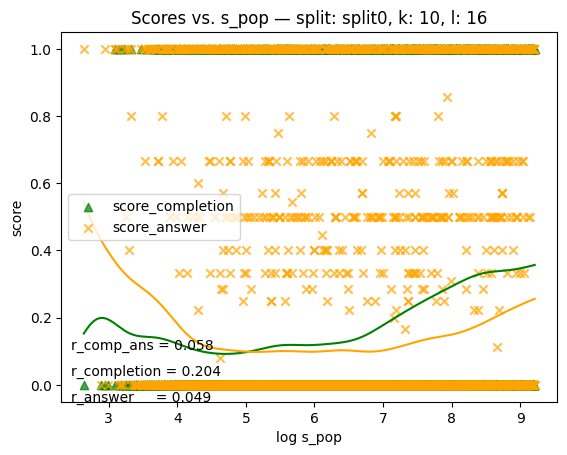

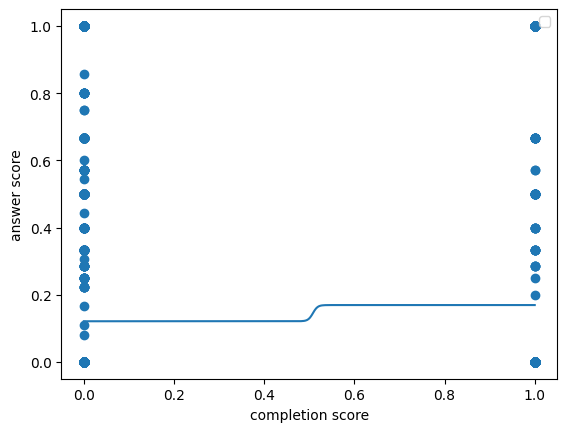

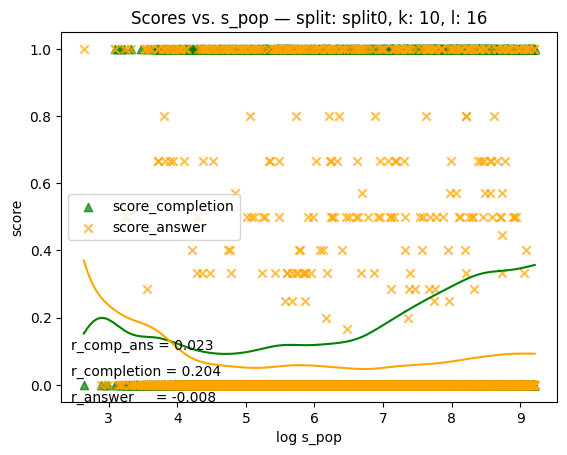

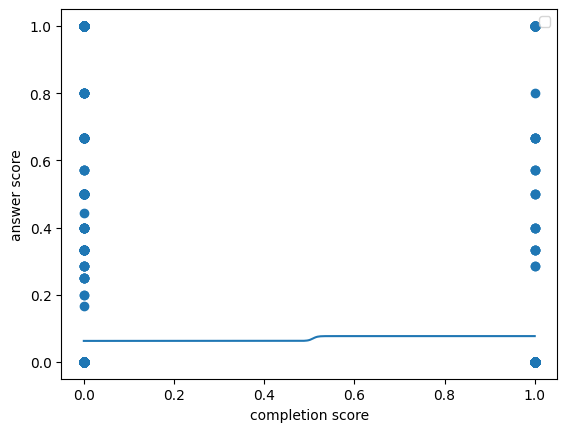

In [111]:
scatter_scores(results, 'split0', 10, 16, ans_key='score_answer_know', subsplits=["0_to_1000", '1000_to_10000'], comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 16, ans_key='score_answer', subsplits=["0_to_1000", '1000_to_10000'], comp_threshold=0.5)

/tmp/ipykernel_1186871/1855056830.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'r_completion': 0.033121212125289505, 'r_answer': 0.1907688858983513}

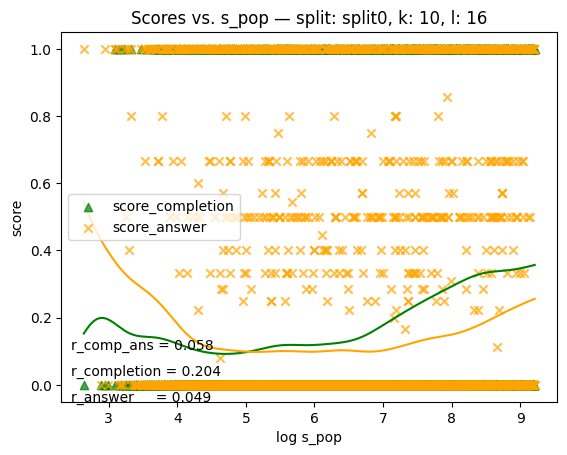

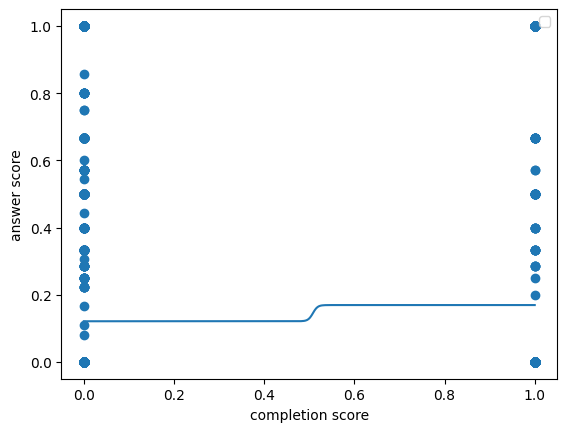

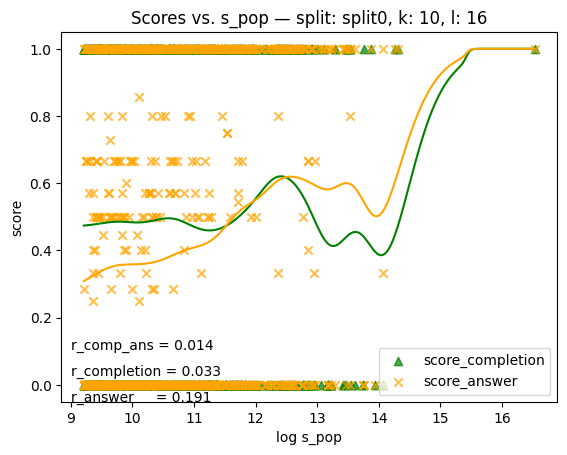

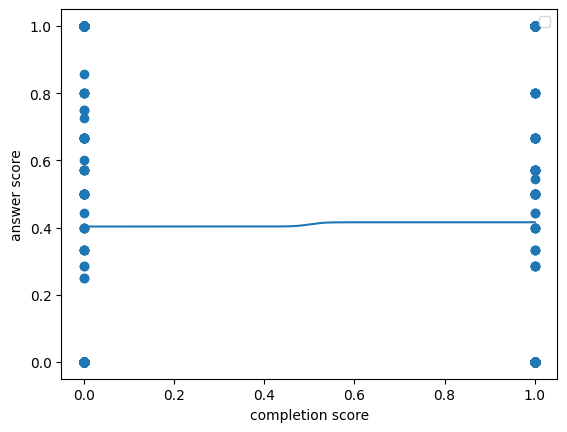

In [112]:
scatter_scores(results, 'split0', 10, 16, ans_key='score_answer_know', subsplits=["0_to_1000", '1000_to_10000'], comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 16, ans_key='score_answer_know', subsplits=["10000_to_100000", '100000_to_inf'], comp_threshold=0.5)

/tmp/ipykernel_1186871/1855056830.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'r_completion': 0.29212680981044914, 'r_answer': 0.2855715704463557}

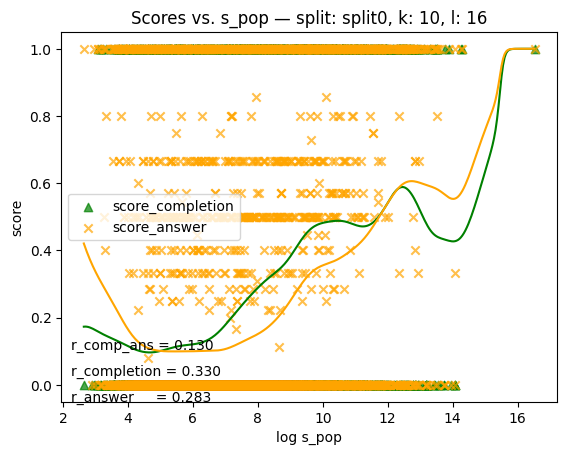

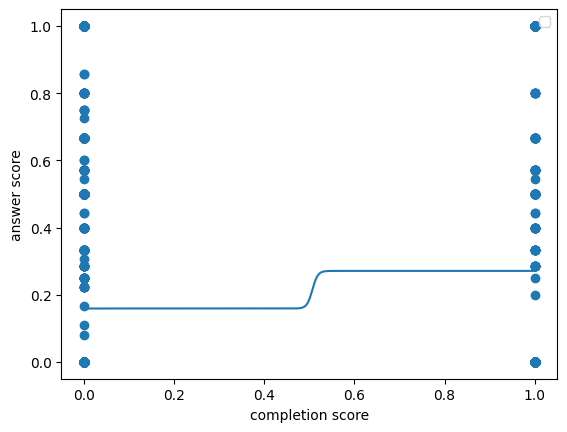

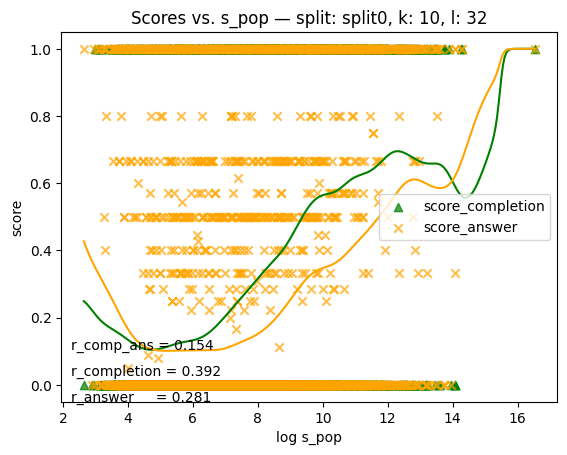

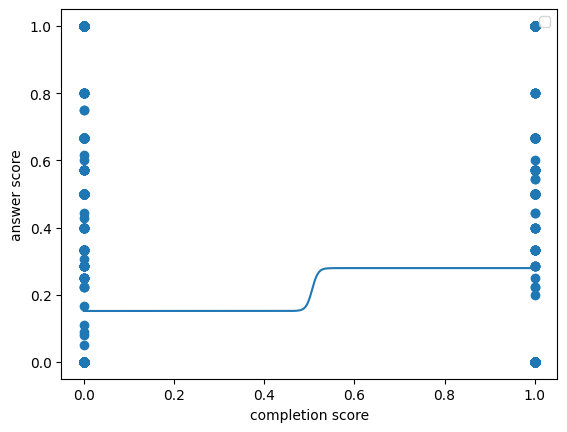

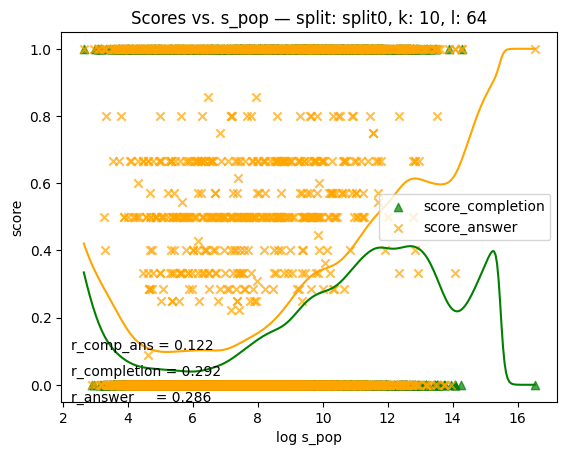

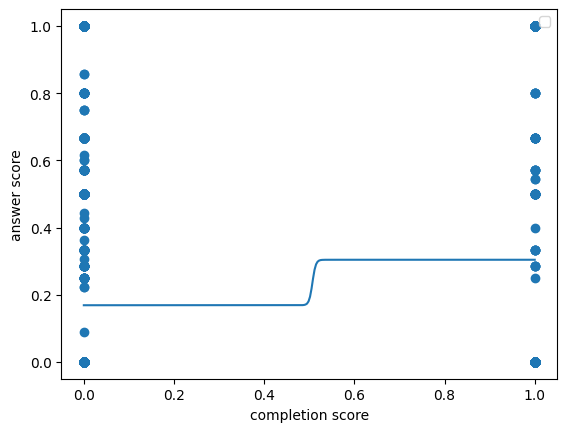

In [113]:
scatter_scores(results, 'split0', 10, 16, ans_key='score_answer_know', comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 32, ans_key='score_answer_know', comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 64, ans_key='score_answer_know', comp_threshold=0.5)

/tmp/ipykernel_1186871/1855056830.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


{'r_completion': 0.29212680981044914, 'r_answer': 0.13748122797495752}

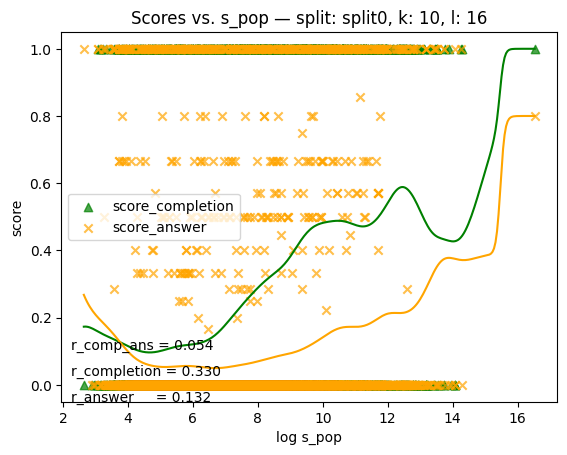

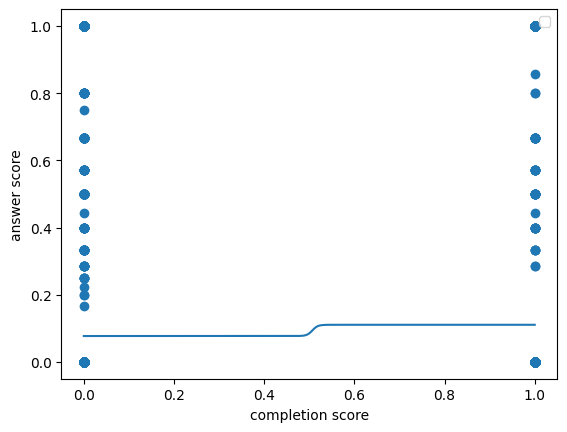

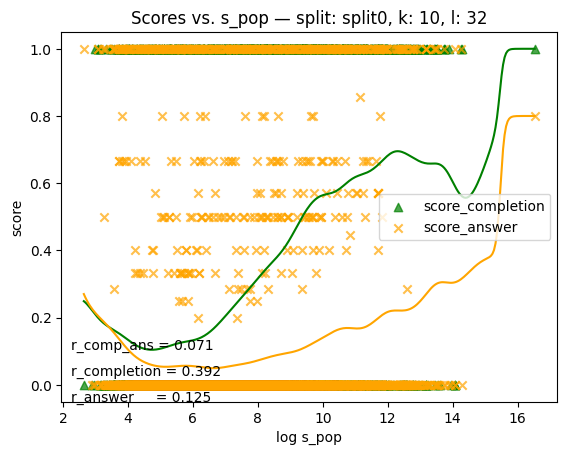

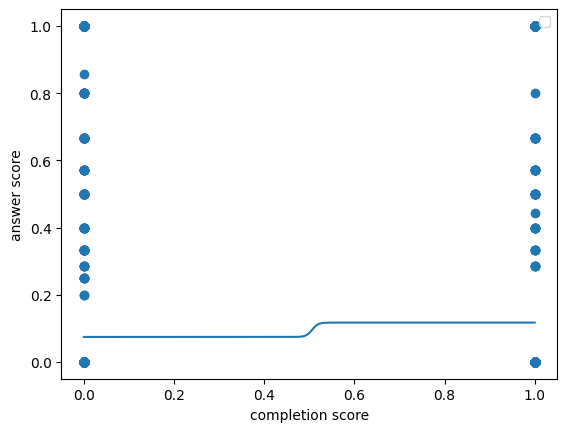

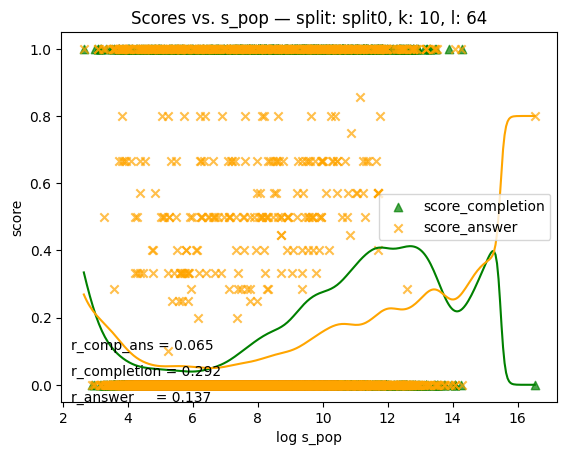

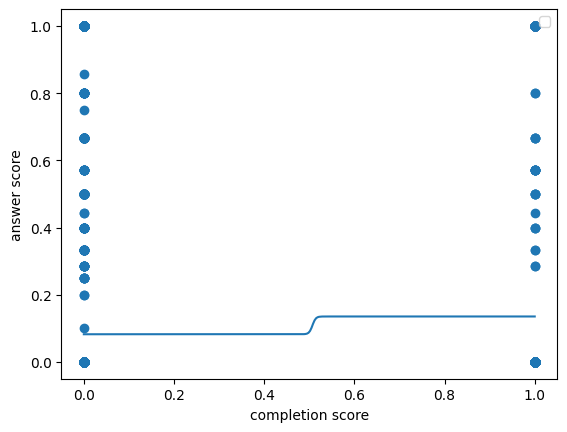

In [114]:
scatter_scores(results, 'split0', 10, 16, comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 32, comp_threshold=0.5)
scatter_scores(results, 'split0', 10, 64, comp_threshold=0.5)

In [36]:
from datasets import load_dataset
import json
k = 10
l = 32
for split in range(1):
    for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
        dataset = load_dataset('parquet', data_files=f"../data/raw/splits/fifty_fifty/split{split}/{freq}/dev.decon.wikilinked.parquet")['train']
        cnt = 0
        for i in range(len(dataset)):
            instance = dataset[i]
            if len(instance['s_docs']) == 0: continue
            q = instance['question']
            a = instance['possible_answers']
            for doc in instance['s_docs']:
                print(doc['text'][:200])
            print('-----')



Back Home (Chuck Berry album)

Back Home is the fourteenth studio album by Chuck Berry, released in 1970 by Chess Records. The album title refers to his return to Chess after several years with Mercur
-----
Early Spring (1986 film)

Early Spring () is a 1986 Danish drama film directed by Astrid Henning-Jensen. It was entered into the 15th Moscow International Film Festival. The film is based on the novel
-----
Richard Rawlinson

Richard Rawlinson FRS (3 January 1690 – 6 April 1755) was an English clergyman and antiquarian collector of books and manuscripts, which he bequeathed to the Bodleian Library, Oxfor
-----
Andries Bonger

Andries Bonger (20 May 1861 – 20 January 1936) was a Dutch art collector, as well as Johanna van Gogh-Bonger's brother and Theo van Gogh's friend, who later became his brother-in-law.

-----
Off the Road

Off the Road: Twenty Years with Cassady, Kerouac and Ginsberg is an autobiographical book by Carolyn Cassady. Originally published in 1990 as "Off the Road: M

dict_keys(['split0'])

In [51]:
from openai import OpenAI
import sys
if ".." not in sys.path:
    sys.path.append('..')
from score_rouge import compute_score
import re


client_base = OpenAI(base_url='http://nid001536:8001/v1', api_key="EMPTY")
client_ins = OpenAI(base_url='http://nid001533:8001/v1', api_key="EMPTY")
model_base = 'allenai/OLMo-2-1124-7B'
model_ins = 'allenai/OLMo-2-1124-7B-Instruct'
def get_completion(prefix, model=model_base, temperature=0, max_completion_tokens=32):
    output = client_base.completions.create(model=model, prompt=prefix, max_tokens= max_completion_tokens, temperature=temperature)
    return output.choices[0].text

def get_answer(question, model=model_ins, temperature=0, max_completion_tokens=1024):
    output = client_ins.chat.completions.create(model=model, messages=[{
                "role": "system",
                "content": "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>."
            }, {'role': 'user', 'content': question}], max_completion_tokens=max_completion_tokens, temperature=temperature)
    return output.choices[0].message.content

def extract_answer(solution_str):
    return re.findall(r'<answer>(.*?)</answer>', solution_str, re.IGNORECASE)[0]

from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [56]:
import json
print('[ref completion]', completion)
print('[ref len]', len(tokenizer_base(completion)['input_ids']))
r1 = get_completion(prefix)
print('[response]', r1)
print(compute_score(None, f"<answer>{r1}</answer>", json.dumps([completion]), None)['acc'])
print('[question]', q)
print('[ref answer]', a)
r2 = get_answer(q)
print('[answer]', r2)
print(compute_score(None, r2, a, None)['acc'])


[ref completion]  a 1985 American science fiction film directed by Robert Zemeckis and written by Zemeckis, and Bob Gale. It stars Michael J.
[ref len] 32
[response]  a 1985 American science fiction comedy film directed by Robert Zemeckis and written by Zemeckis and Bob Gale. It stars Michael J.
0.9767441860465117
[question] What genre is Back to the Future?
[ref answer] ["comedy film", "comedy movie", "science fiction film", "sci-fi film", "science fiction movie", "sci-fi movie", "scifi film", "scifi movie", "sci fi film", "sci fi movie", "scifi-film", "scifi"]
[answer] <thought>Back to the Future is a science fiction film.</thought> <answer>Science Fiction</answer>
0.8


# Example
[ref completion]  a 1985 American science fiction film directed by Robert Zemeckis and written by Zemeckis, and Bob Gale. It stars Michael J.

[response]  a 1985 American science fiction comedy film directed by Robert Zemeckis and written by Zemeckis and Bob Gale. It stars Michael J. Fox, Christopher Lloyd, Lea Thompson, and

[question] What genre is Back to the Future?

[ref answer] ["comedy film", "comedy movie", "science fiction film", "sci-fi film", "science fiction movie", "sci-fi movie", "scifi film", "scifi movie", "sci fi film", "sci fi movie", "scifi-film", "scifi"]

[answer] "Back to the Future" is primarily a science fiction film. It combines elements of adventure, comedy, and drama, but the core of its narrative revolves around time travel, which is a central theme of science fiction. The movie follows the protagonist, Marty McFly, who travels back in time from 1985 to 1955 in a DeLorean car that has been modified to function as a time machine. The story explores the consequences of altering the past and the efforts to set things right, which are typical themes in science fiction narratives involving time travel.